In [14]:
import test_config as cfg
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import os, os.path
import pickle
import io

import skimage
import skimage.io, skimage.transform, skimage.filters
import scipy.ndimage

import sys
sys.path.append(r'../src/')

import importlib
import transform
import filters
import local_radon
import skew_line
importlib.reload(transform)
importlib.reload(filters)
importlib.reload(local_radon)
importlib.reload(skew_line)

<module 'skew_line' from '../src\\skew_line.py'>

D:/Data/bujo_sample\20190309_125151.jpg
Wall time: 1.21 s


C:\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


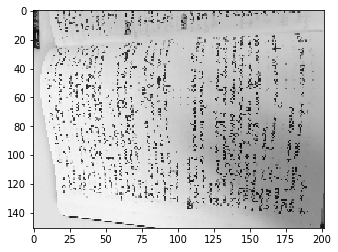

In [2]:
%%time
src_fname = os.path.join(cfg.sample_path, os.listdir(cfg.sample_path)[6])
print(src_fname)
src = skimage.io.imread(src_fname, as_grey=True)

src2 = skimage.transform.rescale(src, scale=0.05)
plt.imshow(src2, cmap='gray')

C:\Anaconda3\lib\site-packages\skimage\transform\radon_transform.py:69: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Text angles is 0.0
Text line delta is 9
Wall time: 262 ms


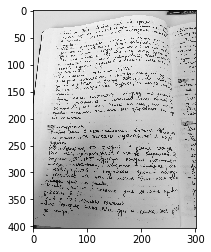

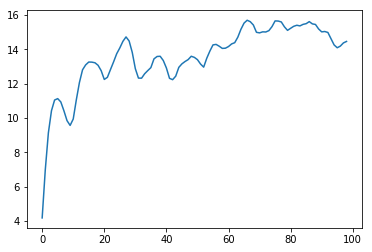

In [3]:
%%time
text_angle = transform.get_text_angle(src2)
print('Text angles is {}'.format(text_angle[0][0]))

src3 = skimage.transform.rotate(skimage.transform.rescale(src, scale=0.1), -90.0-text_angle[0][0], resize=True)
plt.figure()
plt.imshow(src3, cmap='gray')

text_line_delta, text_line_deltas = transform.get_text_line_delta(src3)
plt.figure()
plt.plot(text_line_deltas)
print('Text line delta is {}'.format(text_line_delta))

Wall time: 64.1 ms


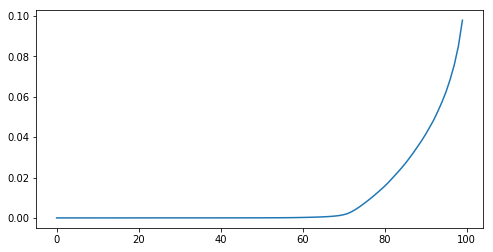

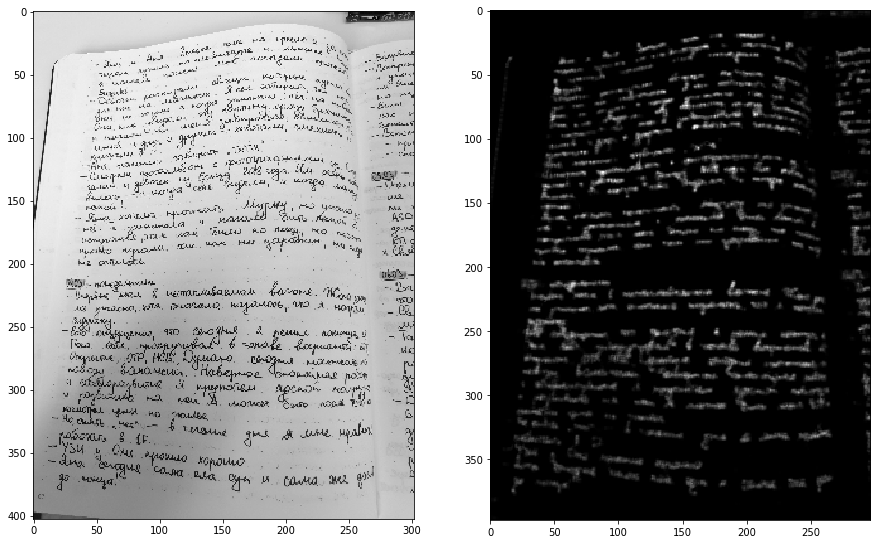

In [4]:
%%time
src4 = transform.filter_variance(src3, (text_line_delta//2, text_line_delta//2), 50, 50)
text_cutoff = np.percentile(src4, 90)/2

plt.figure(figsize=(8,4))
plt.plot(np.percentile(src4, range(100)))

plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(src3, cmap='gray')
plt.subplot(122)
plt.imshow(src4, cmap='gray')

C:\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[(-1.5466302294595904, -64.0, 0, 162, 1677)]
Wall time: 117 ms


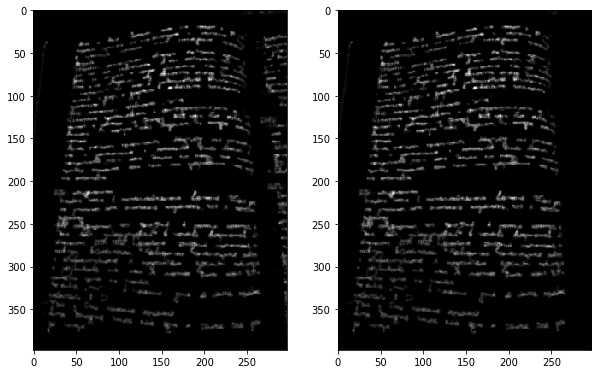

In [5]:
%%time
src5 = skimage.transform.rescale(src4>text_cutoff, scale=0.25)>0.0
src6 = skimage.filters.gaussian(src5, sigma=0.2)>0.4

vsplits = transform.search_region_vsplit(src6, np.pi*3/8, num_angles=131,
                                         window_size_1d=15, max_value=2, zero_threshold=10,
                                         min_split_abs=100, max_split_pct=0.10)

src7 = transform.erase_regions(src4, vsplits, dsz=4)
print(vsplits)

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(src4, cmap='gray')
plt.subplot(122)
plt.imshow(src7, cmap='gray')

Wall time: 1 s


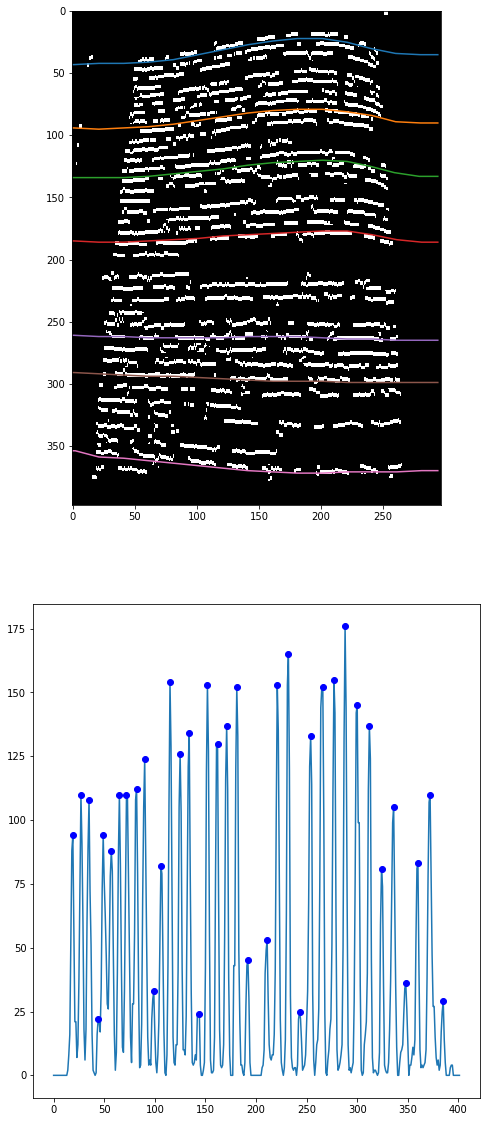

In [20]:
%%time
src8 = filters.local_maxima_v(src7, 1, text_line_delta//2, text_cutoff)*1.0

theta = np.linspace(-np.pi/4, np.pi/4, 91)
rgrid = local_radon.create_grid(src8, theta)

rj0, rj1 = transform.get_array_range(np.mean(src8, axis=0), 50)
ri0, ri1 = transform.get_array_range(np.mean(src8[:,rj0:rj1], axis=1), 75)

src8h = np.mean(src8[:,rj0:rj1], axis=1)
rows = np.concatenate(([ri0], transform.get_sparse_max_points(src8h, ri0+30, ri1-30, 30, 60), [ri1]))

curves = [np.array(skew_line.make_curve_2way(i, (rj0+rj1)//2, 20, src8, rgrid, theta, (40, 50), reg_coef=0.125, reg_power=1.0)) for i in rows]

ires, imeta = skew_line.integrate_curves(src8, curves)
ids = select_text_lines(ires, 5, 10, minmax_ratio=0.8)

plt.figure(figsize=(8,20))
plt.subplot(211)
plt.imshow(src8, cmap='gray')
for crv in curves:
    plt.plot(crv[:,1], crv[:,0])
    
plt.subplot(212)
plt.plot(ires)
for i in ids:
    plt.plot(i, ires[i], 'bo')

Wall time: 55.1 ms


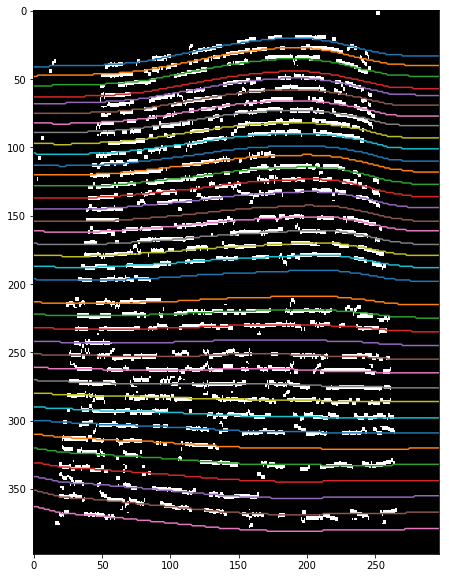

In [22]:
%%time
plt.figure(figsize=(8,10))
plt.imshow(src8, cmap='gray')
for i in ids:
    if len(imeta[i])>2:
        tmp_j, tmp_i = skew_line.interpolate_between_curves(np.arange(src8.shape[1]), 0, src8.shape[0]-1, imeta[i][0], imeta[i][1], imeta[i][2])
    else:
        tmp_j, tmp_i = skew_line.offset_curve(np.arange(src8.shape[1]), imeta[i][0], imeta[i][1])
    plt.plot(tmp_j, tmp_i)
    #print(type(imeta[i][0]))

In [19]:
def select_text_lines(arr1d, window_size, min_value, minmax_ratio):
    ids0 = local_radon.get_local_maximas_1d(arr1d, window_size, min_value)
    ids1 = []
    msk = (ids0[1:]==(ids0[:-1]+1))
    i = 0
    while i < len(ids0):
        k = 0
        while i < len(msk) and msk[i]:
            i += 1
            k += 1
        
        ids1.append(ids0[i-k//2])
        i += 1
        
    ids1 = [i for i in ids1 if max(np.min(arr1d[max(0, i-window_size):(i+1)]),np.min(arr1d[i:min(len(arr1d), i+window_size+1)]))/arr1d[i] < minmax_ratio]
    
    ids2 = []
    i = 0
    while i < len(ids1):
        if i < len(ids1)-1:
            if abs(ids1[i]-ids1[i+1]) < window_size and arr1d[ids1[i+1]]>arr1d[ids1[i]]:
                i += 1
                continue
        if i > 0:
            if abs(ids1[i]-ids1[i-1]) < window_size and arr1d[ids1[i-1]]>arr1d[ids1[i]]:
                i += 1
                continue
        ids2.append(ids1[i])
        i += 1
    return ids2